In [1]:
import pyteomics.mgf
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import pandas_utils as pu
import numpy as np

In [2]:
def save_fig(file_name):
    plt.savefig(r"C:\git\msn_library\figures/{}.png".format(file_name), dpi=300)
    plt.savefig(r"C:\git\msn_library\figures/{}.pdf".format(file_name))
    plt.savefig(r"C:\git\msn_library\figures/{}.svg".format(file_name))

sns.set_theme(font_scale=2, style="white")

In [3]:
method1 = r"C:\git\msn_library\library\method_comparison\20231113_mce_library_pos_AGC40_Res15K_lib_MSn.mgf"
method2 = r"C:\git\msn_library\library\method_comparison\20231113_mce_library_pos_AGC100_Res15K_lib_MSn.mgf"
method3 = r"C:\git\msn_library\library\method_comparison\20231113_mce_library_pos_AGC100_Res60K_lib_MSn.mgf"

In [4]:
def read_mgf(infile):
    import re
    rows = []
    counter = 0
    
    with pyteomics.mgf.MGF(infile) as f_in:
        for spectrum_dict in tqdm(f_in):
            if spectrum_dict is not None:
                rows.append(spectrum_dict["params"])
            else:
                counter += 1
    
    df = pd.DataFrame(rows)
    if "inchikey" not in df.columns:
        df["inchikey"] = df["inchiaux"]
    if "compound_name" not in df.columns:
        df["compound_name"] = df["name"]
    if "monoisotopic_mass" not in df.columns:
        df["monoisotopic_mass"] = df["exactmass"]
    #
    if "usi" in df.columns:
        df["unique_sample_id"] = ["pluskal{}_id".format(re.search(r'pluskal(.*?)_id', usi).group(1))  for usi in df["usi"]]
    return df

In [5]:
method1_df = read_mgf(method1)
method2_df = read_mgf(method2)
method3_df = read_mgf(method3)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
method1_df["method"] = "40AGC"
method2_df["method"] = "100AGC"
method3_df["method"] = "100AGC_60KRes"

In [7]:
merged_df = pd.concat([method1_df, method2_df, method3_df], ignore_index=True)
merged_df["num peaks"] = merged_df["num peaks"].astype(int)
merged_df["mslevel"] = merged_df["mslevel"].astype(int)


In [8]:
merged_df

,name,description,exactmass,formula,inchi,inchiaux,smiles,feature_id,mslevel,rtinseconds,...,msn_precursor_mzs,msn_fragmentation_methods,msn_isolation_windows,other_matched_compounds,other_matched_compounds_names,inchikey,compound_name,monoisotopic_mass,unique_sample_id,method
0,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,-1,2,79.53,...,NaN,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC
1,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,-1,2,79.53,...,NaN,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC
2,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,1080,2,79.53,...,NaN,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC
3,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,-1,2,79.53,...,NaN,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC
4,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,-1,2,79.53,...,NaN,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,AZD3514,MCE bioactive compounds,519.256958,C25H32F3N7O2,InChI=1S/C25H32F3N7O2/c1-18(36)33-14-12-32(13-...,JMEYDSHPKCSIJC-UHFFFAOYSA-N,CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)...,-1,3,71.03,...,"[520.263122558594, 112.075477600098]","[HCD, HCD]","[1.2000000476839432, 2.0]",NaN,NaN,JMEYDSHPKCSIJC-UHFFFAOYSA-N,AZD3514,519.256958,pluskal_mce_1D1_A3_id,100AGC_60KRes
28064,AZD3514,MCE bioactive compounds,519.256958,C25H32F3N7O2,InChI=1S/C25H32F3N7O2/c1-18(36)33-14-12-32(13-...,JMEYDSHPKCSIJC-UHFFFAOYSA-N,CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)...,-1,3,71.03,...,"[520.263122558594, 112.075477600098]","[HCD, HCD]","[1.2000000476839432, 2.0]",NaN,NaN,JMEYDSHPKCSIJC-UHFFFAOYSA-N,AZD3514,519.256958,pluskal_mce_1D1_A3_id,100AGC_60KRes
28065,AZD3514,MCE bioactive compounds,519.256958,C25H32F3N7O2,InChI=1S/C25H32F3N7O2/c1-18(36)33-14-12-32(13-...,JMEYDSHPKCSIJC-UHFFFAOYSA-N,CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)...,192,3,71.03,...,"[520.263122558594, 112.075477600098]","[HCD, HCD]","[1.2000000476839432, 2.0]",NaN,NaN,JMEYDSHPKCSIJC-UHFFFAOYSA-N,AZD3514,519.256958,pluskal_mce_1D1_A3_id,100AGC_60KRes
28066,AZD3514,MCE bioactive compounds,519.256958,C25H32F3N7O2,InChI=1S/C25H32F3N7O2/c1-18(36)33-14-12-32(13-...,JMEYDSHPKCSIJC-UHFFFAOYSA-N,CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)...,191,3,71.03,...,"[520.263122558594, 112.075477600098]","[HCD, HCD]","[1.2000000476839432, 2.0]",NaN,NaN,JMEYDSHPKCSIJC-UHFFFAOYSA-N,AZD3514,519.256958,pluskal_mce_1D1_A3_id,100AGC_60KRes


In [9]:
merged_df["method"].value_counts()

100AGC_60KRes    9685
100AGC           9432
40AGC            8951
Name: method, dtype: int64

In [10]:
evaluation_bins = [0, 0.5, 1, 2, 3, 4, 6, 10, 20, 50, 100, np.inf]
group_names =     ["0", '1', '2', '3', '4', '5-6', '7-10', '11-20', '21-50', '51-100', '>100']


merged_df["signals_simple"] = pd.cut(merged_df['num peaks'], bins=evaluation_bins,
                                  labels=group_names, include_lowest=True, right=True)

In [11]:
merged_df

,name,description,exactmass,formula,inchi,inchiaux,smiles,feature_id,mslevel,rtinseconds,...,msn_fragmentation_methods,msn_isolation_windows,other_matched_compounds,other_matched_compounds_names,inchikey,compound_name,monoisotopic_mass,unique_sample_id,method,signals_simple
0,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,-1,2,79.53,...,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC,21-50
1,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,-1,2,79.53,...,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC,21-50
2,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,1080,2,79.53,...,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC,11-20
3,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,-1,2,79.53,...,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC,11-20
4,Radafaxine,MCE bioactive compounds,255.102606,C13H18ClNO2,"InChI=1S/C13H18ClNO2/c1-9-13(16,17-8-12(2,3)15...",RCOBKSKAZMVBHT-TVQRCGJNSA-N,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cc(Cl)ccc1,-1,2,79.53,...,NaN,NaN,NaN,NaN,RCOBKSKAZMVBHT-TVQRCGJNSA-N,Radafaxine,255.102606,pluskal_mce_1D1_A3_id,40AGC,11-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,AZD3514,MCE bioactive compounds,519.256958,C25H32F3N7O2,InChI=1S/C25H32F3N7O2/c1-18(36)33-14-12-32(13-...,JMEYDSHPKCSIJC-UHFFFAOYSA-N,CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)...,-1,3,71.03,...,"[HCD, HCD]","[1.2000000476839432, 2.0]",NaN,NaN,JMEYDSHPKCSIJC-UHFFFAOYSA-N,AZD3514,519.256958,pluskal_mce_1D1_A3_id,100AGC_60KRes,11-20
28064,AZD3514,MCE bioactive compounds,519.256958,C25H32F3N7O2,InChI=1S/C25H32F3N7O2/c1-18(36)33-14-12-32(13-...,JMEYDSHPKCSIJC-UHFFFAOYSA-N,CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)...,-1,3,71.03,...,"[HCD, HCD]","[1.2000000476839432, 2.0]",NaN,NaN,JMEYDSHPKCSIJC-UHFFFAOYSA-N,AZD3514,519.256958,pluskal_mce_1D1_A3_id,100AGC_60KRes,11-20
28065,AZD3514,MCE bioactive compounds,519.256958,C25H32F3N7O2,InChI=1S/C25H32F3N7O2/c1-18(36)33-14-12-32(13-...,JMEYDSHPKCSIJC-UHFFFAOYSA-N,CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)...,192,3,71.03,...,"[HCD, HCD]","[1.2000000476839432, 2.0]",NaN,NaN,JMEYDSHPKCSIJC-UHFFFAOYSA-N,AZD3514,519.256958,pluskal_mce_1D1_A3_id,100AGC_60KRes,11-20
28066,AZD3514,MCE bioactive compounds,519.256958,C25H32F3N7O2,InChI=1S/C25H32F3N7O2/c1-18(36)33-14-12-32(13-...,JMEYDSHPKCSIJC-UHFFFAOYSA-N,CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)...,191,3,71.03,...,"[HCD, HCD]","[1.2000000476839432, 2.0]",NaN,NaN,JMEYDSHPKCSIJC-UHFFFAOYSA-N,AZD3514,519.256958,pluskal_mce_1D1_A3_id,100AGC_60KRes,11-20


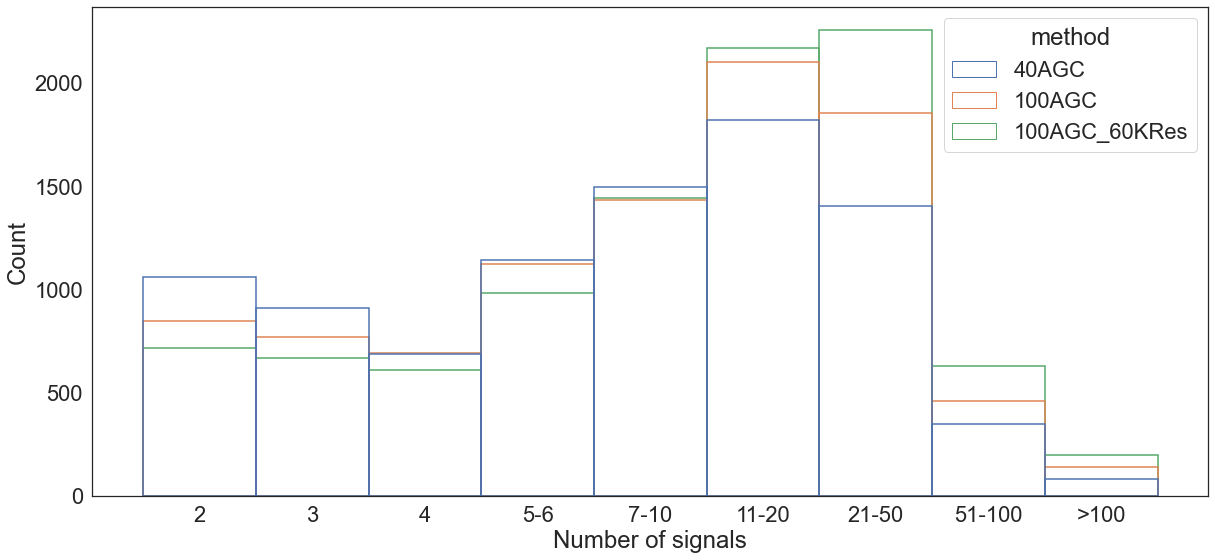

In [12]:
figure_name = "n_signals_categories_method_comparison"
plt.figure(figsize=(20, 9))
# sns.set_style("white")
ax = sns.histplot(data=merged_df, x="signals_simple", hue="method", fill=False)
plt.xlabel("Number of signals")
plt.ylabel("Count")

save_fig(figure_name)

In [13]:
mslevel3 = merged_df[merged_df['mslevel'] >= 3]

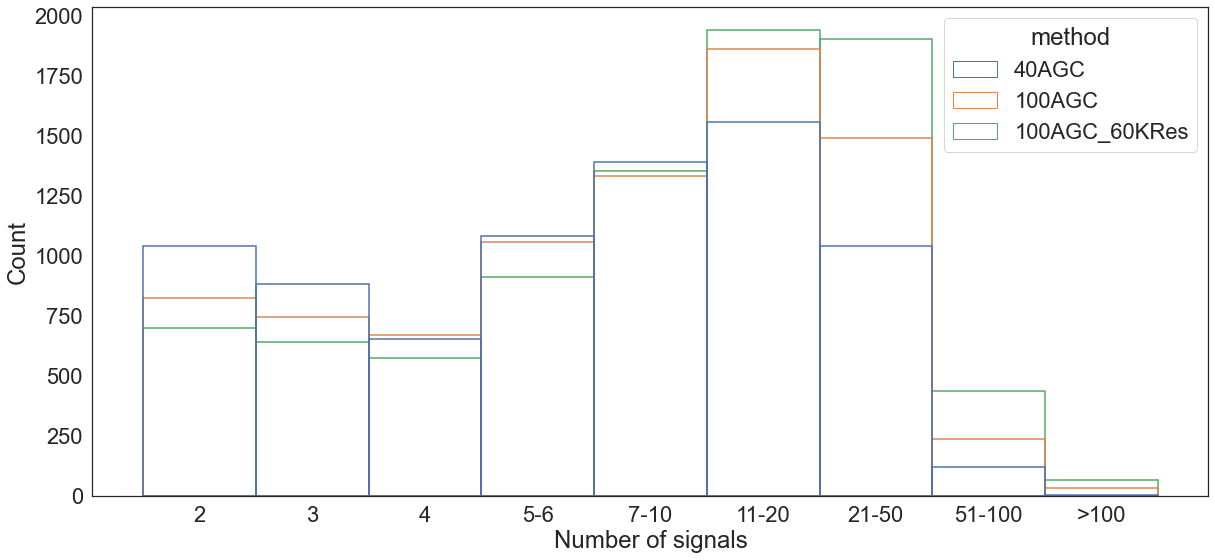

In [14]:
figure_name = "n_signals_categories_method_comparison_mslevel3"
plt.figure(figsize=(20, 9))
# sns.set_style("white")
ax = sns.histplot(data=mslevel3, x="signals_simple", hue="method", fill=False)
plt.xlabel("Number of signals")
plt.ylabel("Count")

save_fig(figure_name)

In [15]:
best_df = merged_df.sort_values('num peaks', ascending=False).drop_duplicates(['unique_sample_id', "compound_name", "method"], keep="first").sort_index()

In [16]:
best_df["method"].value_counts()

40AGC            185
100AGC           185
100AGC_60KRes    184
Name: method, dtype: int64

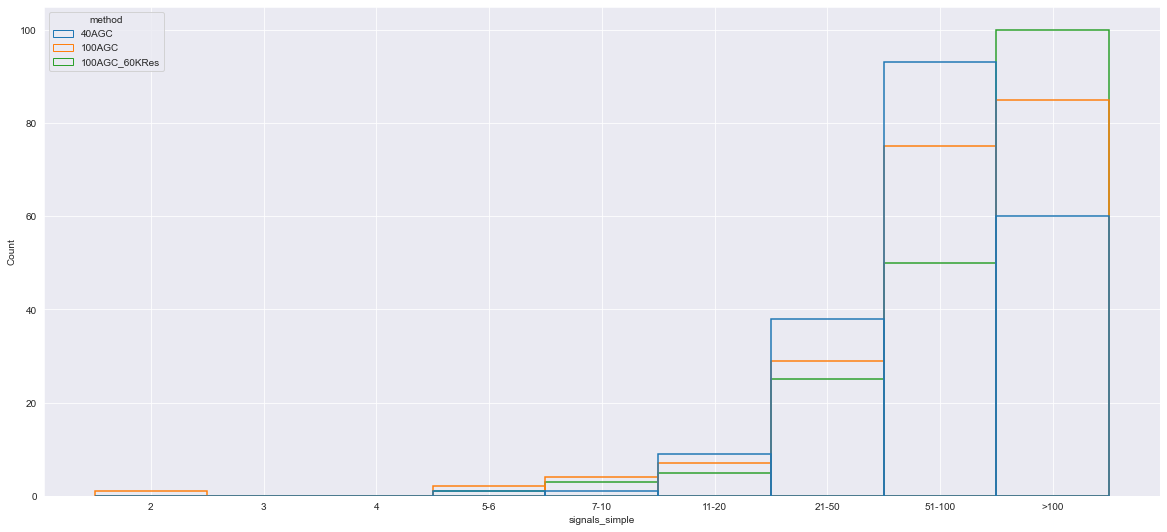

In [20]:
plt.figure(figsize=(20, 9))
ax = sns.histplot(data=best_df, x="signals_simple", hue="method", fill=False)
# save_fig("n_signals_best_filtered_categories_pp")